In [6]:
pip install tensorflow numpy matplotlib opencv-python scikit-learn

--- 1. Checking Google Drive Connection ---
 Drive already mounted.
 Found the folder directly in Drive: /content/drive/MyDrive/archive (1)
 NOTE: Training directly from Drive is slow. It is recommended to copy/unzip to /content/

--- Searching for Infection Segmentation Data inside: /content/drive/MyDrive/archive (1) ---
 SUCCESS! Dataset found at: /content/drive/MyDrive/archive (1)/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19
• Images: 1864
• Masks: 1864

--- Visualization ---


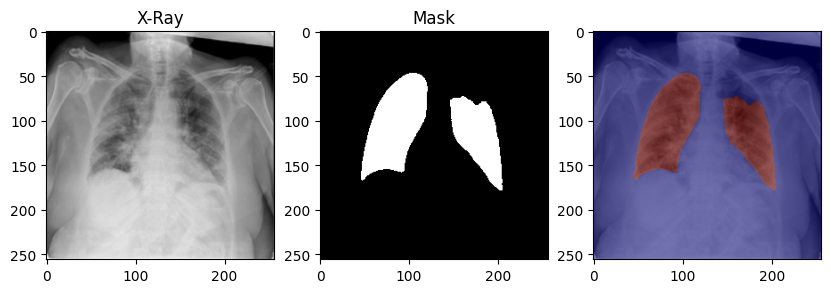

In [12]:
import os
import zipfile
import glob
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Drive
print("--- 1. Checking Google Drive Connection ---")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print(" Drive already mounted.")

# CONFIGURATION

possible_drive_folder = "/content/drive/MyDrive/archive (1)"

extract_dest = "/content/temp_dataset"

target_path = None

if os.path.exists(possible_drive_folder):
    print(f" Found the folder directly in Drive: {possible_drive_folder}")
    print(" NOTE: Training directly from Drive is slow. It is recommended to copy/unzip to /content/")
    search_root = possible_drive_folder

elif os.path.exists(possible_zip_path):
    print(f" Found zip file in Drive: {possible_zip_path}")
    print(f" Extracting to {extract_dest} (this makes training faster)...")

    if not os.path.exists(extract_dest):
        os.makedirs(extract_dest)

    with zipfile.ZipFile(possible_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dest)
    print(" Extraction Complete.")
    search_root = extract_dest

else:
    print(" Could not find 'archive (1)' folder or zip in the root of MyDrive.")
    print(" Searching MyDrive for any file named 'archive*.zip'...")
    found_zips = glob.glob("/content/drive/MyDrive/**/archive*.zip", recursive=True)

    if len(found_zips) > 0:
        print(f" Found a similar zip: {found_zips[0]}")
        possible_zip_path = found_zips[0]
        # Recursively call extraction
        print(f"⏳ Extracting {possible_zip_path} to {extract_dest}...")
        with zipfile.ZipFile(possible_zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dest)
        search_root = extract_dest
    else:
        print(" CRITICAL ERROR: Could not find the dataset in Drive.")
        print(" Please manually check the path in Drive and update 'possible_zip_path' in the code.")
        search_root = None

if search_root:
    print(f"\n--- Searching for Infection Segmentation Data inside: {search_root} ---")

    final_covid_path = None

    for root, dirs, files in os.walk(search_root):
        if "COVID-19" in dirs:
            candidate = os.path.join(root, "COVID-19")
            if "Infection" in candidate and "Train" in candidate:
                final_covid_path = candidate
                break
            if final_covid_path is None and "Train" in candidate:
                final_covid_path = candidate

    if final_covid_path:
        print(f" SUCCESS! Dataset found at: {final_covid_path}")

        # Load Images
        img_paths = sorted(glob.glob(os.path.join(final_covid_path, "images", "*.png")))
        mask_paths = sorted(glob.glob(os.path.join(final_covid_path, "infection masks", "*.png")))

        print(f"• Images: {len(img_paths)}")
        print(f"• Masks: {len(mask_paths)}")

        # Visualize
        if len(img_paths) > 0:
            print("\n--- Visualization ---")
            img = cv2.imread(img_paths[0], cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)
            plt.figure(figsize=(10, 4))
            plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("X-Ray")
            plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("Mask")
            plt.subplot(1,3,3); plt.imshow(img, cmap='gray'); plt.imshow(mask, cmap='jet', alpha=0.5)
            plt.show()

            # EXPORT VARIABLES FOR NEXT STEP
            train_img_paths = img_paths
            train_mask_paths = mask_paths
        else:
            print(" Folder empty.")
    else:
        print(" Error: Extracted the files, but could not find 'COVID-19' folder inside.")

In [13]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, img_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_img_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            # Load and Resize Image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0  # Normalize to [0, 1]
            img = np.expand_dims(img, axis=-1)

            # Load and Resize Mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size)
            mask = mask / 255.0
            mask = (mask > 0.5).astype(np.float32) # Binarize
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create generators
from sklearn.model_selection import train_test_split

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(train_img_paths, train_mask_paths, test_size=0.2, random_state=42)

train_gen = DataGenerator(X_train, y_train, batch_size=16)
val_gen = DataGenerator(X_val, y_val, batch_size=16)

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # --- Encoder ---
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # --- Decoder ---
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs=[inputs], outputs=[outputs])

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 1,946,305 (7.42 MB)

 Trainable params: 1,946,305 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define Dice Coefficient and Loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef, 'accuracy'])

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # Increase to 20-50 for better results
    verbose=1
)

Epoch 1/10
65/93 ━━━━━━━━━━━━━━━━━━━━ 14:38 31s/step - accuracy: 0.2263 - dice_coef: 0.2103 - loss: 0.7897

In [ ]:
# Get a batch of data
val_images, val_masks = val_gen.__getitem__(0)

# Predict
preds = model.predict(val_images)

# Visualize result
def plot_prediction(img, true_mask, pred_mask):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("X-Ray Image")
    plt.imshow(img.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("AI Prediction")
    plt.imshow(pred_mask.squeeze() > 0.5, cmap='gray') # Threshold probability

    plt.show()

# Show first image in batch
plot_prediction(val_images[0], val_masks[0], preds[0])